<a href="https://colab.research.google.com/github/mlarthack/ami/blob/master/deepdream_loops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on https://github.com/ml4a/ml4a-guides/blob/master/notebooks/neural-synth.ipynb by Gene Kogan

a collection of feature vizualizations for googlenet can be found at https://distill.pub/2017/feature-visualization/appendix/



In [6]:
  #Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.
!wget -P . https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip inception5h.zip -d inception5h/
!rm inception5h.zip

--2019-10-28 08:24:36--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘./inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   106MB/s    in 0.4s    

2019-10-28 08:24:36 (106 MB/s) - ‘./inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: inception5h/tensorflow_inception_graph.pb  
  inflating: inception5h/LICENSE     


In [7]:
# get some functions from ml4a repository
!wget https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py

--2019-10-28 08:24:43--  https://raw.githubusercontent.com/ml4a/ml4a-guides/master/notebooks/lapnorm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4608 (4.5K) [text/plain]
Saving to: ‘lapnorm.py’

lapnorm.py          100%[===================>]   4.50K  --.-KB/s    in 0s      

2019-10-28 08:24:43 (73.2 MB/s) - ‘lapnorm.py’ saved [4608/4608]



To get started, make sure all of the folloing import statements work without error. You should get a message telling you there are 59 layers in the network and 7548 channels.

In [8]:
# install deprecated version of scipy
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [2]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf

import imageio

# import everything from lapnorm.py
from lapnorm import *


Instructions for updating:
Use tf.gfile.GFile.


Number of layers 59
Total number of feature channels: 7548



Let's inspect the network now. The following will give us the name of all the layers in the network, as well as the number of channels they contain. We can use this as a lookup table when selecting channels.

In [10]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

conv2d0_pre_relu 64
conv2d1_pre_relu 64
conv2d2_pre_relu 192
mixed3a_1x1_pre_relu 64
mixed3a_3x3_bottleneck_pre_relu 96
mixed3a_3x3_pre_relu 128
mixed3a_5x5_bottleneck_pre_relu 16
mixed3a_5x5_pre_relu 32
mixed3a_pool_reduce_pre_relu 32
mixed3b_1x1_pre_relu 128
mixed3b_3x3_bottleneck_pre_relu 128
mixed3b_3x3_pre_relu 192
mixed3b_5x5_bottleneck_pre_relu 32
mixed3b_5x5_pre_relu 96
mixed3b_pool_reduce_pre_relu 64
mixed4a_1x1_pre_relu 192
mixed4a_3x3_bottleneck_pre_relu 96
mixed4a_3x3_pre_relu 204
mixed4a_5x5_bottleneck_pre_relu 16
mixed4a_5x5_pre_relu 48
mixed4a_pool_reduce_pre_relu 64
mixed4b_1x1_pre_relu 160
mixed4b_3x3_bottleneck_pre_relu 112
mixed4b_3x3_pre_relu 224
mixed4b_5x5_bottleneck_pre_relu 24
mixed4b_5x5_pre_relu 64
mixed4b_pool_reduce_pre_relu 64
mixed4c_1x1_pre_relu 128
mixed4c_3x3_bottleneck_pre_relu 128
mixed4c_3x3_pre_relu 256
mixed4c_5x5_bottleneck_pre_relu 24
mixed4c_5x5_pre_relu 64
mixed4c_pool_reduce_pre_relu 64
mixed4d_1x1_pre_relu 112
mixed4d_3x3_bottleneck_pre_relu 

In [0]:
def save_image(name, im, fmt='jpeg'):
    im = np.uint8(np.clip(im/255., 0, 1)*255)
    with open('{}.jpg'.format(name), 'w') as f:
      PIL.Image.fromarray(im).save(f, fmt)

def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

## params



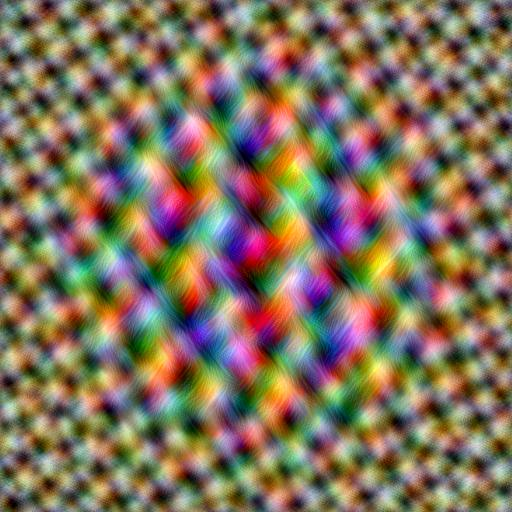

In [20]:
# SET 

h, w = 512, 512  # image size

LEN = 90  # animation lenght in frames

crop_px = 10  # from each side of the frame

# upload black and white image to be used as mask
mask_template = load_image('/content/blurred_circle.jpg', h, w)

obj1 = ('mixed3b', 15)  # white objective
obj2 = ('mixed3b', 7)  # black objective

mask_template = mask_template[:,:,0]  # Will use only one channel for binary mask

# VIZUALIZE
display_image(mask_template)

h, w = mask_template.shape

mask = np.ones((h, w, 2))

mask[:, :, 0] = mask_template / 255
mask[:, :, 1] = 1.0 - (mask_template / 255)


img0 = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T(obj1[0])[:,:,:,obj1[1]], 
              T(obj2[0])[:,:,:,obj2[1]]]

# check how it looks, 400 iterations for saturation
img = lapnorm_multi(objectives, img0, mask, iter_n=90, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)
display_image(img) 


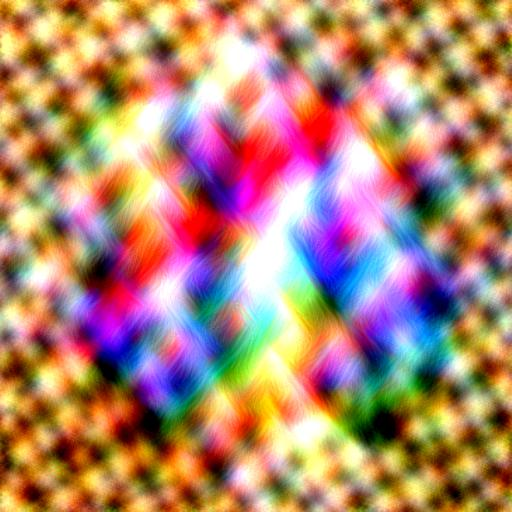

done


In [21]:
# repeat the generation loop 20 times. notice the feedback -- we make img and then use it the initial input 
for f in range(LEN):
    print("iteration {}".format(f))
    img = lapnorm_multi(objectives, img, mask, iter_n=20, step=1.0, oct_n=octave_n, oct_s=octave_scale, lap_n=4)
    display_image(img)    # let's see it
    save_image('frame%05d'%f, img)  # ffmpeg to save the frames
    img = resize(img[crop_px:-crop_px,crop_px:-crop_px,:], (h, w))  # before looping back, crop the border by 10 pixels, resize, repeat

print('done')

In [0]:
# making things loop

# start the last frame

img = imageio.imread('frame{:05d}.jpg'.format(LEN - 1))

# space = np.cos(np.linspace(0, np.pi, LEN-1)) / 2 + 0.5
space = np.linspace(1, 0, LEN - 1)


for f in range(LEN - 1):
    print("iteration {}. using {} of prev and {} of next img".format(f, space[f], 1 - space[f]))
    try:
      img_combined = img * space[f] + imageio.imread('frame{:05d}.jpg'.format(f+1)) * (1-space[f])
      # display_image(img_combined)
    except Exception as e:
      print(e)

      
    img = lapnorm_multi(objectives, img_combined, mask, iter_n=20, step=1.0, oct_n=3, oct_s=octave_scale, lap_n=4)
    # display_image(img)    # let's see it
    save_image('looped_frame%05d'%f, img)
    
    img = resize(img[crop_px:-crop_px,crop_px:-crop_px,:], (h, w)) 



In [23]:
print('video_{}{}_{}{}'.format(*obj1, *obj2))

video_mixed3b15_mixed3b7


In [24]:
!ffmpeg -f image2 -r 30 -vb 20M -pattern_type glob -i 'looped_frame*.jpg' video_mixed3b15_mixed3b7.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena